In [2]:
%matplotlib inline
import altair as alt
import pandas as pd
import numpy as np
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
data = pd.read_csv('abalone.data', names=['Sex','Length',
                                        'Diameter','Height',
                                        'Whole weight', 'Shucked weight', 
                                        'Viscera weight', 'Shell weight', 
                                        'Rings'])

In [4]:
data = data[data.Height > 0]
data = data[data.Height < 0.4]

In [5]:
brush = alt.selection(type='interval')
#A = ['M', 'F', 'I']
ratings = ['M', 'F', 'I']

rating_radio = alt.binding_radio(options=ratings)

rating_select = alt.selection_single(fields=['Sex'], bind=rating_radio, name="Sex")
rating_color_condition = alt.condition(rating_select,
                      alt.Color('Sex:N', legend=None),
                      alt.value('lightgray'))


In [6]:
# Main Chart
# the top scatterplot
HeightLengthScatter = alt.Chart(title='Height + Length').mark_point(filled = True).encode(
    x='Length:Q',
    y='Height:Q',
    size='Diameter:Q',
    opacity=alt.value(0.5),
    color=alt.condition(brush, 'Sex:N', alt.value('lightgray')),
    
).properties(
    selection=brush,
    width=650,
    
).add_selection(
    rating_select
).encode(
    color=rating_color_condition,
    tooltip=['Height', 'Length', 'Diameter', 'Rings', 'Sex']
)

x = data.Length
y = data.Height
df = pd.DataFrame({'x': x, 'y': y})

# Define the degree of the polynomial fit
degree_list = [1]

# Build a dataframe with the fitted data
poly_data = pd.DataFrame({'xfit': np.linspace(df['x'].min(), df['x'].max(), 500)})
for degree in degree_list:
    poly_data[str(degree)] = np.poly1d(np.polyfit(df['x'], df['y'], degree))(poly_data['xfit'])

# Plot the best fit polynomials
height_length_polynomial_fit = alt.Chart(poly_data).transform_fold(
    ['1'],
    as_=['degree', 'yfit']
).mark_line().encode(
    x='xfit:Q',
    y='yfit:Q',
    color='degree:N'
)


In [7]:

# the right Category Bar Chart
sexChart = alt.Chart(title='Sex Total').mark_bar().encode(
    y='count()',
    color='Sex:N',
    x='Sex:N'
).transform_filter(
    brush.ref()
).encode(
    color=rating_color_condition
).properties(
    width=200
)

sexText = sexChart.mark_text(
    align='left',
    baseline='middle',
    dy=-5 # Nudges text to the right so it doesn't appear on the top of the bar.
).encode(
    text='count()'
)

'''legend = alt.Chart().mark_point().encode(
            y=alt.Y('Sex:N', axis=alt.Axis(orient='right')),
            color='Sex'
).add_selection(
    selection
)'''


"legend = alt.Chart().mark_point().encode(\n            y=alt.Y('Sex:N', axis=alt.Axis(orient='right')),\n            color='Sex'\n).add_selection(\n    selection\n)"

In [8]:
noOfRings = alt.Chart(title='Count of Rings').mark_bar().encode(
    x='mean(Rings)',
    y='Sex:N',
    color='Sex:N',
).transform_filter(
    brush.ref()
).properties(
    width = 850, 
    #height = 150
).encode(
    color=rating_color_condition
)

ringText = noOfRings.mark_text(
    align='left',
    baseline='middle',
    dx=3 # Nudges text to the right so it doesn't appear on the top of the bar.
).encode(
    text='count()'
)



In [9]:
lengthDiameterScatter = alt.Chart().mark_point().encode(
    x='Length:Q',
    y='Diameter:Q',
    color='Sex:N'
).transform_filter(
    brush.ref()
).properties(
    width = 250
).encode(
    color=rating_color_condition
).interactive()



In [10]:
heightDiameterScatter = alt.Chart().mark_point().encode(
    x='Height:Q',
    y=alt.Y('Diameter:Q', 
          scale=alt.Scale(zero=False)),
    color='Sex:N'
).transform_filter(
    brush.ref()
).properties(
    width = 250
).encode(
    color=rating_color_condition
).interactive()




In [11]:
shellWholeWeightScatter = alt.Chart().mark_point().encode(
    y='Shell weight:Q',
    x='Whole weight:Q',
    color='Sex:N',
    tooltip=['Height', 'Length', 'Diameter', 'Rings', 'Sex']
).transform_filter(
    brush.ref()
).properties(
    width = 250
).encode(
    color=rating_color_condition
).interactive()

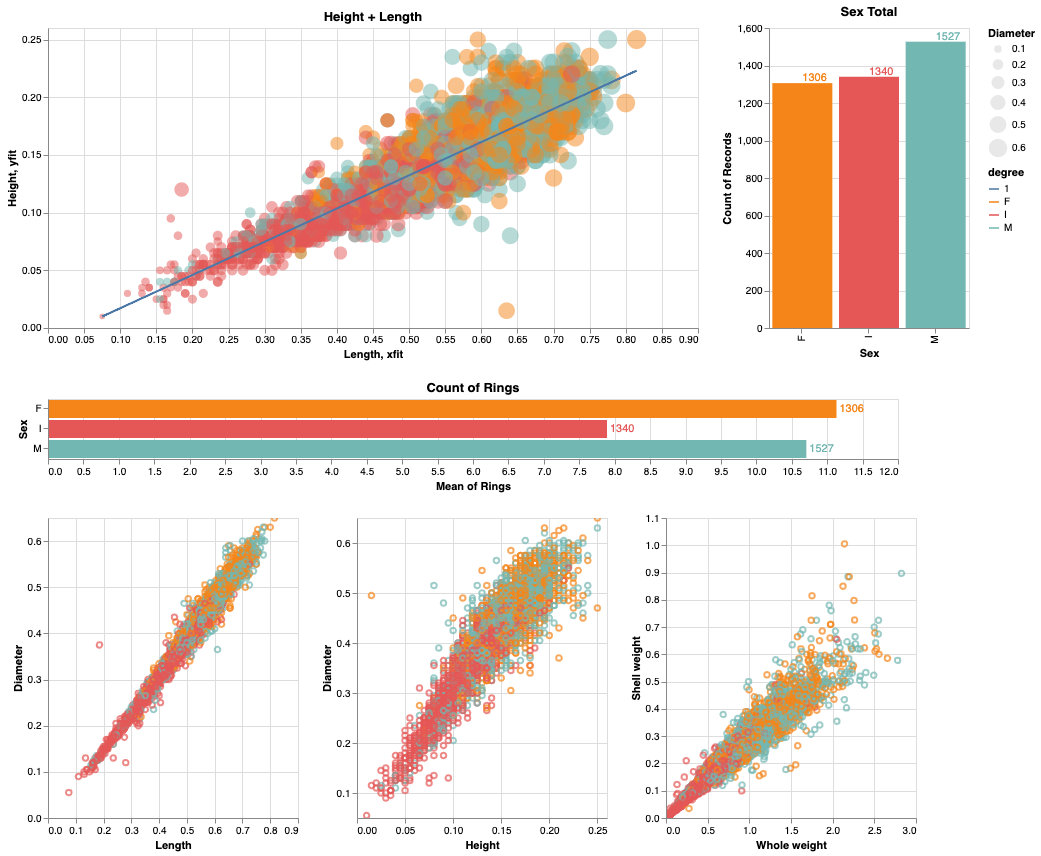

In [12]:
#Display Chart

chart = alt.vconcat((HeightLengthScatter + height_length_polynomial_fit) | (sexChart + sexText), 
                    (noOfRings + ringText), 
                    lengthDiameterScatter | heightDiameterScatter | shellWholeWeightScatter, 
                    data=data)
chart